In [41]:
import numpy as np
import math
import random as rd
from sympy.parsing.sympy_parser import parse_expr
from sympy import Symbol, IndexedBase
from sympy import *
import re
from scipy.stats import poisson
from typing import Sequence, Tuple
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
from cirq.contrib.svg import SVGCircuit
from tensorflow.keras import initializers
from numpy import linalg as LA
from numpy.random import random
from random import choices

## Standard QAOA

In [42]:
k = 3 #length of clauses
n_var = 4 #number of variables
nqubits = n_var #number of qubits in the circuit
all_vars = [i for i in range(-n_var,n_var+1)]
all_vars = [i for i in all_vars if i != 0]

In [43]:
r_by_k = {2 : 1, 3: 6.43, 4: 20.43, 6: 70.21, 8: 176.54, 10: 708.92, 16: 45425.2}

def generate_instance(k: int, n: int) -> np.ndarray:
    #generate an instance of random k-SAT with n variables in the satisfiability threshold
    if not (r := r_by_k.get(k)):
        raise ValueError(f"k must be in {list(r_by_k)} (got {k})")
    m = poisson(r*n).rvs()
    #return np.random.choice(all_vars, size=(m, k))
    all_variables = []
    all_signs = []
    for i in range(m):
        #all_signs.append([rd.choice(l) for i in range(k)])
        all_variables.append(choices(all_vars, k = k))

    all_variables = np.array(all_variables)
    #all_signs = np.array(all_signs)
    return all_variables

In [44]:
def dimacs_writer(dimacs_filename, cnf_array):
    #writes the dimacs file with the CNF
    cnf = cnf_array
    cnf_length = len(cnf)
    n_sat = len(cnf[0])
    var_num = np.max(cnf) 
    with open(dimacs_filename, "w") as f:

        f.write('c DIMACS file CNF '+str(n_sat)+'-SAT \n')
        f.write("p cnf {} {}\n".format(var_num, cnf_length))
        
        for i, clause in enumerate(cnf):
            line = clause.tolist()
            if i == cnf_length - 1:
                s = ' '.join(str(x) for x in line)+' 0'
                f.write(s)
            else: 
                s = ' '.join(str(x) for x in line)+' 0 \n'
                f.write(s)

In [45]:
class Verifier():
    #verifier from Qiskit page, takes a bit string and checks if cnf is satisfied
    def __init__(self, dimacs_file):
        with open(dimacs_file, 'r') as f:
            self.dimacs = f.read()

    def is_correct(self, guess):
        # Convert characters to bools & reverse
        guess = [bool(int(x)) for x in guess][::-1]
        for line in self.dimacs.split('\n'):
            line = line.strip(' 0')
            clause_eval = False
            for literal in line.split(' '):
                if literal in ['p', 'c']:
                    # line is not a clause
                    clause_eval = True
                    break
                if '-' in literal:
                    literal = literal.strip('-')
                    lit_eval = not guess[int(literal)-1]
                else:
                    lit_eval = guess[int(literal)-1]
                clause_eval |= lit_eval
            if clause_eval is False:
                return False
        return True

In [46]:
def generate_binary_strings(bit_count):
    binary_strings = []
    def genbin(n, bs=''):
        if len(bs) == n:
            binary_strings.append(bs)
        else:
            genbin(n, bs + '0')
            genbin(n, bs + '1')

    genbin(bit_count)
    return binary_strings

binary_strings = generate_binary_strings(nqubits)

In [47]:
valid_keys = []
dimacs_filename = "random_cnf.dimacs" 

while not valid_keys:
    #only accepts satisfiable CNFs
    inst = generate_instance(k, n_var)
    dimacs_writer(dimacs_filename, inst)
    v = Verifier('random_cnf.dimacs')
    
    for key in binary_strings:
        if v.is_correct(key) == True:
            print(key) 
            valid_keys.append(key)

1111


In [48]:
with open('random_cnf.dimacs', 'r') as f:
    dimacs_file = f.read()

statement = []

for line in dimacs_file.split('\n'):
    #make lists for each clause in the cnf file
    
    line = line.strip(' 0')
    clause = []
    for literal in line.split(' '):
            if literal in ['p', 'c']:
            # line is not a clause
                break
            else:
                #print(literal)
                clause.append(int(literal))
    statement.append(clause)

new_stat = [ele for ele in statement if ele != []]

In [49]:
#write all clauses symbollically, proceed with product and sum of Z terms

Z = IndexedBase('Z')
i= symbols('i', cls=Idx)

all_clauses = []
for i in range(len(new_stat)):
    clauses_z = []
    for literal in new_stat[i]:
        #print(literal)
        if literal < 0:
            literal_exp = 1 - Z[abs(literal)]
        else:
            literal_exp = 1 + Z[abs(literal)]
        clauses_z.append(literal_exp)
    all_clauses.append(clauses_z)
    
clauses_list = []
for clause in all_clauses:
    clauses_list.append(expand(np.prod(clause)))
    
total_clause = np.sum(clauses_list)

In [50]:
#an awkward way to get rid of powers of Z

power_dict = {Z[1]**2 : 1, Z[2]**2 : 1, Z[3]**2 : 1, Z[4]**2 : 1, 
              Z[5]**2 : 1, Z[6]**2 : 1, Z[7]**2 : 1, Z[8]**2 : 1, Z[1]**3 : Z[1], 
              Z[2]**3 : Z[2], Z[3]**3 : Z[3], Z[4]**3 : Z[4], Z[5]**3 : Z[5], Z[6]**3 : Z[6], Z[7]**3 : Z[7]}

In [51]:
total_clause = np.sum(clauses_list)
total_clause = total_clause.subs(power_dict)

In [52]:
def clause_transformer(clause):
    #critical element: takes a clause and maps it into a tuple containing the coeffcient and the 
    #indices for z operators which are going into the circuit and hamiltonian functions. It's not totally general, so needs to be checked
    #for larger k and number of variables. So far seems to work ok
    all_args = Add.make_args(clause)

    crcs = []

    for arg in all_args:
        elem = str(arg)
        if elem[0] == '-' and elem[1] == 'Z':
            coef = -1
            #print(coef)

        if elem[0] == 'Z':
            coef = 1
            #print(coef)

        if elem[0] == '-' and elem[1] != 'Z':
            if elem[2].isdigit() == True:
                coef = -int(str(elem[1])+str(elem[2]))
            else:
                coef = -int(elem[1])
            #print(coef)

        if elem[0].isdigit() == True:
            if elem[1].isdigit() == True:
                coef = int(str(elem[0])+str(elem[1]))
                #print(coef)
            else:
                coef = int(str(elem[0]))
                #print(coef)

        zz_terms = re.findall(r"\[(\d+)\]", elem)
        zz_list = []
        for elem in zz_terms:
            zz_list.append(int(elem) - 1)
        zz_list

        if not zz_list:
            crcs.append(coef)
        else:
            crcs.append((coef, zz_list))
    
    return crcs

In [53]:
total_clause

Z[1]*Z[2]*Z[3] + Z[1]*Z[2]*Z[4] + 2*Z[1]*Z[2] + 2*Z[1]*Z[3]*Z[4] + 3*Z[1]*Z[3] - 5*Z[1]*Z[4] + Z[2]*Z[3]*Z[4] - 4*Z[2]*Z[4] - Z[2] - 3*Z[3]*Z[4] + 4*Z[3] + 4*Z[4] + 19

In [54]:
clause_to_circ = clause_transformer(total_clause)

In [55]:
qubits = []

for i in range(nqubits):
    qubits.append(cirq.GridQubit(0,i))        
    
qubits = list(reversed(qubits)) #don't know why
all_qubits = [i for i in range(nqubits)]

In [56]:
def z_string_gates(z_inds, par):
    #here we write z strings as a single parametrized z rotation and cnots
    z_string = []
    cnot_gates = []

    pairs = list(zip([z_inds[0] for i in range(len(z_inds))], z_inds[1:]))

    for pair in pairs:

        cnot_gates.append(cirq.CNOT(qubits[pair[1]], qubits[pair[0]]))
    z_string.append(cnot_gates)
    z_string.append(cirq.rz(par).on(qubits[pair[0]]))
    z_string.append(cnot_gates[len(cnot_gates) - 1::-1])
    return z_string

In [57]:
def hamiltonian_circuit(circuit, qubits, par, clauses): 
    for elem in clauses:  
        if (type(elem) is tuple) == False:
            pass # ignoring the constant term in the Hamiltonian
        else:
            coef = elem[0]
            z_inds = elem[1]
            if len(z_inds) == 1:
                circuit.append(cirq.rz(coef*par).on(qubits[z_inds[0]]))
            else:
                circuit.append(z_string_gates(z_inds,coef*par))
    return circuit

In [58]:
def mixing_circuit(circuit, qubits, par):
    for i in range(len(qubits)):
        circuit.append(cirq.rx(par).on(qubits[i]))
    return circuit

In [59]:
def cost_hamiltonian(qubits, clauses):
    h = 0
    for elem in clauses:
        res = type(elem) is tuple  
        if res == False:
            for qubit in qubits:
                pass
                #circuit.append(cirq.I(qubit))
        else:
            coef = elem[0]
            z_inds = elem[1]
            h += coef*math.prod([cirq.Z(qubits[i]) for i in z_inds])
    return h

In [60]:
qaoa_circuit = cirq.Circuit()
p = 5 #number of layers. When in doubt, stay on the lower side

num_param = 2 * p 
parameters = symbols("q0:%d" % num_param)

#setting up the layers
for i in range(p):
    qaoa_circuit = hamiltonian_circuit(qaoa_circuit, qubits, parameters[2 * i], clause_to_circ)
    qaoa_circuit = mixing_circuit(qaoa_circuit, qubits, parameters[2 * i + 1])

In [61]:
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, initial_learning_rate):
        self.initial_learning_rate = initial_learning_rate

    def __call__(self, step):
        return self.initial_learning_rate / (step+1)


In [62]:
cost = cost_hamiltonian(qubits, clause_to_circ)

initial = cirq.Circuit()

for qubit in qubits:
    initial.append(cirq.H(qubit)) #applying Hadamard to all qubits before running circuit

#setting up the model
lr = 0.1
inputs = tfq.convert_to_tensor([initial])
ins = tf.keras.layers.Input(shape = (), dtype = tf.dtypes.string)
outs = tfq.layers.PQC(qaoa_circuit, cost)(ins)
ksat = tf.keras.models.Model(inputs = ins, outputs = outs)
opt = tf.keras.optimizers.Adam(learning_rate=MyLRSchedule(lr))
ksat.trainable_variables[0].assign([0 for i in range(2*p)]) #initializing angles with some small noise

<tf.Variable 'UnreadVariable' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [63]:
cost_m = cost.matrix()
gs_energy = np.real(min(LA.eig(cost_m)[0]))
gs_energy

-19.0

In [64]:
losses = []
error = 1e2*rd.random()
tol = 1e-1
counter = 0

while abs(gs_energy - error) > tol:
    counter += 1
    previous_error = error   
    with tf.GradientTape() as tape:
        error = ksat(inputs)
    
    grads = tape.gradient(error, ksat.trainable_variables)
    opt.apply_gradients(zip(grads, ksat.trainable_variables))
    error = error.numpy()[0,0]
    losses.append(error)

    print('absolute value of (ground state energy - error) is ' + str(abs(gs_energy - error)), end = '\r')
    #if abs(error - previous_error) < 1e-10:
    #    print('\n got stuck!')
    #    break

KeyboardInterrupt: 

In [65]:
last_error = error

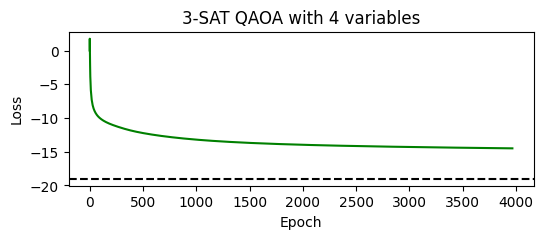

In [66]:
plt.figure(figsize=(6,2))
plt.plot(losses, color = "green")
plt.axhline(y = gs_energy, color = 'black', linestyle = 'dashed')
plt.title(str(k)+'-SAT QAOA with '+str(n_var)+' variables')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
#plt.savefig("TSP_losses")

In [67]:
def to_dec(x):
    return int("".join(str(i) for i in x), 2) 

In [68]:
params = ksat.trainable_variables
print(params)

sample_circuit = tfq.layers.AddCircuit()(inputs, append=qaoa_circuit)
output = tfq.layers.Sample()(sample_circuit, symbol_names=parameters, symbol_values=params, repetitions = 2048)

quantum_preds = []
data = []
for bits in output.values:
    temp = []
    data.append(to_dec(bits.numpy()))
    for pos, bit in enumerate(bits):
        if bit == 1:
            temp.append(pos)
    quantum_preds.append(temp)

[<tf.Variable 'parameters:0' shape=(10,) dtype=float32, numpy=
array([-0.07339655,  0.5879728 , -0.05967907,  0.5831826 , -0.12200559,
        0.60400444, -0.16998518,  0.48729733, -0.16601183,  0.3159373 ],
      dtype=float32)>]


In [69]:
valid_keys

['1111']

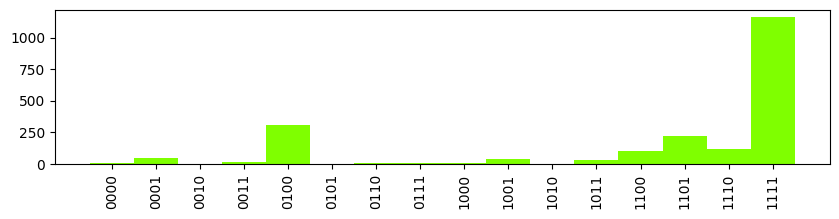

In [70]:
xticks = range(0, 2**nqubits)
xtick_labels = list(map(lambda x: format(x, "0"+str(nqubits)+"b"), xticks))
bins = np.arange(0, 2**nqubits + 1) - 0.5

plt.figure(figsize=(10,2))
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(data, bins=bins, color = "chartreuse", lw=0)
#plt.savefig('hist_custom_sat.pdf')
plt.show()

Random QAOA

In [120]:
qaoa_circuit = cirq.Circuit()
p = 4 #number of layers. When in doubt, stay on the lower side

num_param = 2 * p 
parameters = symbols("q0:%d" % num_param)

#setting up the layers
for i in range(p):
    qaoa_circuit = hamiltonian_circuit(qaoa_circuit, qubits, parameters[2 * i], clause_to_circ)
    qaoa_circuit = mixing_circuit(qaoa_circuit, qubits, parameters[2 * i + 1])

In [121]:
cost = cost_hamiltonian(qubits, clause_to_circ)

initial = cirq.Circuit()

for qubit in qubits:
    initial.append(cirq.H(qubit)) #applying Hadamard to all qubits before running circuit

inputs = tfq.convert_to_tensor([initial])
ins = tf.keras.layers.Input(shape = (), dtype = tf.dtypes.string)
outs = tfq.layers.PQC(qaoa_circuit, cost)(ins)
ksat = tf.keras.models.Model(inputs = ins, outputs = outs)
ksat.trainable_variables[0].assign([rd.uniform(-2*np.pi, 2*np.pi) for i in range(2*p)]) #initializing angles with some small noise

<tf.Variable 'UnreadVariable' shape=(8,) dtype=float32, numpy=
array([-2.9442348 , -0.79650295,  6.2773213 ,  0.7125667 , -5.046065  ,
       -4.846213  , -5.9630775 ,  1.3197839 ], dtype=float32)>

In [122]:
dummy_model = ksat

In [ ]:
losses_dynamical = []
old_error = 1e2*rd.random()
tol = 1e-2
counter = 0
from itertools import cycle

lst = [i for i in range(0,2*p)]
pool = cycle(lst)

for item in pool:
    new_number = rd.uniform(-2*np.pi, 2*np.pi)
    pars = ksat.get_weights()[0]
    new_pars = pars
    new_pars[item] = new_number
    dummy_model.trainable_variables[0].assign(new_pars) 
    if error < old_error:
        print('absolute value of (ground state energy - error) is ' + str(abs(gs_energy - error)) + 'and new parameters are'+str(new_pars), end = '\r')
        ksat.trainable_variables[0].assign(new_pars) 
        old_error = error

absolute value of (ground state energy - error) is tf.Tensor([[13.309087]], shape=(1, 1), dtype=float32)and new parameters are[-2.9247656  -0.79650295  6.2773213   0.7125667  -5.046065   -4.846213


In [ ]:
plt.figure(figsize=(6,2))
plt.plot(losses_dynamical, color = "orange")
plt.plot(losses, color = "green")
plt.axhline(y = gs_energy, color = 'black', linestyle = 'dashed')
plt.title(str(k)+'-SAT QAOA with '+str(n_var)+' variables')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
#plt.savefig("TSP_losses")